## Project: Predicting Stock Prices using time series analysis
## Part 1: Time Series Components
**Source:** https://www.manning.com/liveprojectseries/time-series-for-stock-price-prediction-ser?new=true&experiment=C


### 1. Setting up environment

#### 1.1 Importing packages & setting-up parameters

In [1]:
import requests # to download data from api
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot


# Time Series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller


from sklearn.model_selection import train_test_split


#turning on plot display in JN
%matplotlib inline 
# Setting pandas display options
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 250
pd.options.display.float_format = '{:.4f}'.format

In [2]:
# Import parent directory (main project directory)
# for packages importing
import sys
import os
import pathlib

# Getting the parent directory name in which your script is running
parent = os.path.dirname(os.path.realpath('/'))

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

# now we can import the module in the parent
# directory.

In [3]:
# Adding private parameters
# vantage_api_key
parametersPath = os.path.join(pathlib.Path(os.path.dirname(os.path.realpath(''))).parent.parent.parent, 'Private')
sys.path.append(parametersPath)

from parameters import parameters_private as privparam

In [4]:
# Learning Materials
# https://www.youtube.com/watch?v=ZE_WGBe0_VU # 02417 Lecture 6 part B: Identifying order of ARIMA models 
# https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c
# https://github.com/statsmodels/statsmodels/issues/6851#event-3511269194



#### 1.2 Declaring additional classes & functions

In [5]:
# Function to download data from Alpha Vantage and add date variables
def get_data_vantage(symbol, apikey, start_date = None, end_date = None):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&outputsize=full&symbol={symbol}&apikey={apikey}&datatype=csv'
    data = pd.read_csv(url)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    if start_date is not None and end_date is not None:
        data = data[(data['timestamp'] > start_date) & (data['timestamp'] <= end_date)]
        data["year"] = data["timestamp"].dt.year
        data["quarter"] = data["timestamp"].dt.quarter
        data["month"] = data["timestamp"].dt.month
        data["weekday"] = data["timestamp"].dt.weekday
        data["day"] = data["timestamp"].dt.dayofyear
        data.sort_values(by='timestamp', inplace=True)

    return data

In [6]:
class TSPlots():
    def __init__(self, series_in, title = None, alpha = 0.05, nlags = 30):
        self.series_in = series_in
        self.alpha = alpha
        self.nlags = nlags
        self.title = title
        self._acf()
        self._pacf()
        return

    def _acf(self):
        acfD, confintD, qstatD, pvaluesD = acf(self.series_in, qstat = True, alpha = self.alpha, nlags = self.nlags)
        print('Lags with statistically significant autocorrelation')
        self.acfd = acfD
        self.aconfintD = confintD
        self._count(statistic = self.acfd, ci = self.aconfintD)    
        plot_acf(self.series_in, lags = self.nlags)
        plt.title(f'{self.title} Autocorrelation')
        plt.show()
        return

    def _pacf(self):
        pacfD, pconfintD = pacf(self.series_in, alpha=0.05, nlags=self.nlags)
        print('Lags with statistically significant partial autocorrelation')
        self.pacfd = pacfD
        self.paconfintD = pconfintD    
        self._count(statistic = self.pacfd, ci = self.paconfintD)
        plot_pacf(self.series_in, lags = self.nlags)
        plt.title(f'{self.title} Partial Autocorrelation')
        plt.show()
        return

    def _count(self, statistic, ci):       
        count = 0 
        temp_list = []
        for i in range(1,len(statistic)):
            if abs(statistic[i]) > ci[i][1]-statistic[i]:
                count += 1
                temp_list.append(i)
        if count > 0:
            print(temp_list)
            print('Time series is non random - consider ARMA(p,q) adjustments.')
        return

In [7]:
def adfFunc(series_in, alpha = 0.05):
    adfTest = adfuller(series_in, autolag = 'AIC')
    print('ADF Statistic: %f' % adfTest[0])
    print('p-value: %f' % adfTest[1])
    print('Critical Values:')
    for key, value in adfTest[4].items():
        print('\t%s: %.3f' % (key, value))
    if adfTest[1] < alpha:
        print('Assuming 95% confidence interval we reject null hypothesis that unit root present in the series (stationary series)')
    else:
        print('Assuming 95% confidence interval we have no grounds to reject null hypothesis that unit root present in the series (non-stationary series)')
    return

#### 1.3 Data import and inspection

In [8]:
# Downloading Verizon and AT&T full historic data
# Limiting to required dates - 01/01/2019 to 06/01/2021 
verizon_data = get_data_vantage(symbol = 'VZ', apikey = privparam.vantageApiKey, start_date = '2018-12-31', end_date = '2021-06-01')
att_data = get_data_vantage(symbol = 'T', apikey = privparam.vantageApiKey, start_date = '2018-12-31', end_date = '2021-06-01')

In [9]:
# Inspecting data
print(verizon_data.head())
print(verizon_data.info())
print(att_data.head())
print(att_data.info())

      timestamp    open    high     low   close    volume  year  quarter  \
1171 2019-01-02 56.1600 56.1600 55.2800 56.0200  13969691  2019        1   
1170 2019-01-03 56.3000 56.9900 56.0600 56.2200  19245411  2019        1   
1169 2019-01-04 56.4900 56.8900 55.9500 56.3600  17035848  2019        1   
1168 2019-01-07 56.7600 57.2600 56.5500 56.7200  16348982  2019        1   
1167 2019-01-08 57.2700 58.6900 57.0500 58.3800  21425008  2019        1   

      month  weekday  day  
1171      1        2    2  
1170      1        3    3  
1169      1        4    4  
1168      1        0    7  
1167      1        1    8  
<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 1171 to 564
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  608 non-null    datetime64[ns]
 1   open       608 non-null    float64       
 2   high       608 non-null    float64       
 3   low        608 non-null    float

### 2. Exploratory Data Analysis

#### 2.1 Verizon Communications

Verizon Communications is a US telecom company providing internet, mobile and tv services.  
https://en.wikipedia.org/wiki/Verizon_Communications

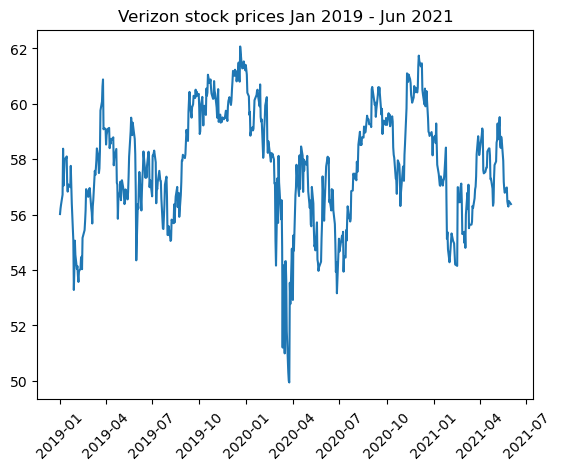

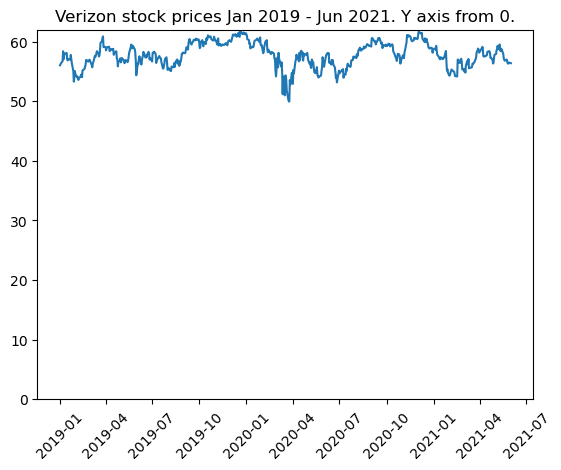

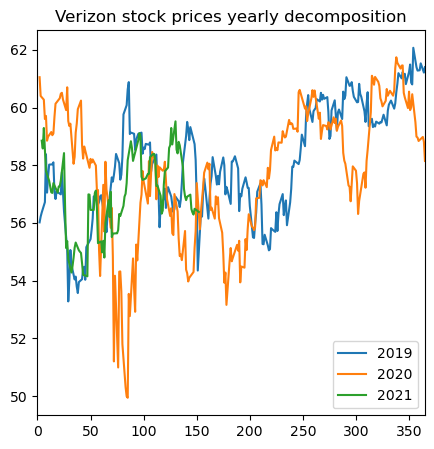

In [10]:
plt.plot(verizon_data['timestamp'], verizon_data['close'], label='Verizon')
plt.xticks(rotation=45)
plt.title('Verizon stock prices Jan 2019 - Jun 2021')
plt.show()
plt.plot(verizon_data['timestamp'], verizon_data['close'], label='Verizon')
plt.xticks(rotation=45)
plt.ylim((0, 62))
plt.title('Verizon stock prices Jan 2019 - Jun 2021. Y axis from 0.') # to see true magnitude of changes
plt.show()
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(verizon_data[verizon_data['year'] == 2019]['day'], verizon_data[verizon_data['year'] == 2019]['close'], label='2019')
ax.plot(verizon_data[verizon_data['year'] == 2020]['day'], verizon_data[verizon_data['year'] == 2020]['close'], label='2020')
ax.plot(verizon_data[verizon_data['year'] == 2021]['day'], verizon_data[verizon_data['year'] == 2021]['close'], label='2021')
plt.xlim((0, 365))
plt.title('Verizon stock prices yearly decomposition')
plt.legend()
plt.show()

Looking at the yearly decomposition of stock valuation it seems that we might have a seasonal component - with valuation slightly higher toward end of the year (maybe because of more time in front of tv or higher internet usage during winter months?). No clearly visible trend.

In [11]:
# How many trading days are in a year?
print(verizon_data['year'].value_counts())
print(att_data['year'].value_counts())
# 2021 has half trading days (data till June)

year
2020    253
2019    252
2021    103
Name: count, dtype: int64
year
2020    253
2019    252
2021    103
Name: count, dtype: int64


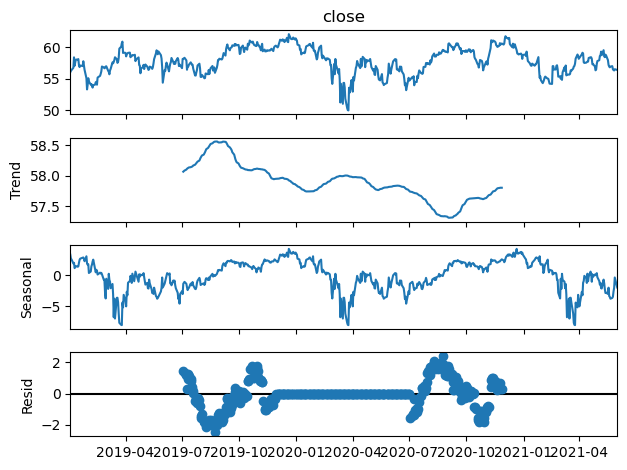

In [12]:
verizon_series = verizon_data.set_index('timestamp')['close'].squeeze()
result = seasonal_decompose(verizon_series, period = 252, model = 'additive') # 252 - number of trading days in a year
result.plot()
pyplot.show()

Based on seasonal seasonal decomposition function:
1) There is a slight downward trend present with mild recovery at the end of trend data. More trend data would be availbe if we analysed a broader timeframe.
2) There is a seasonal component driving stock prices down each April
3) Middle period 2019-12 to 2020-07 seems well explained by seasonal and trend componens (residuals close to 0), while outside those period we have varying remainder

Lags with statistically significant autocorrelation
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Time series is non random - consider ARMA(p,q) adjustments.


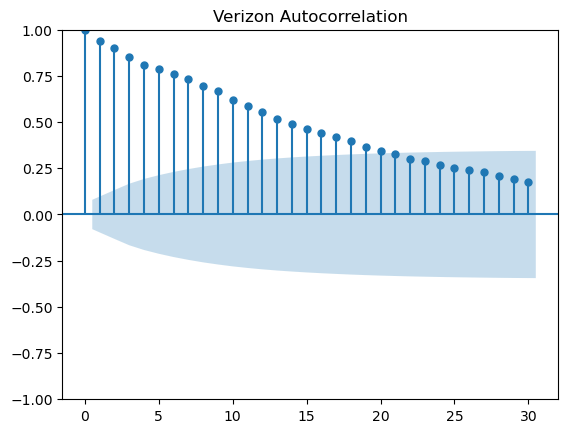

Lags with statistically significant partial autocorrelation
[1, 2, 5, 8, 9, 10, 22, 28]
Time series is non random - consider ARMA(p,q) adjustments.


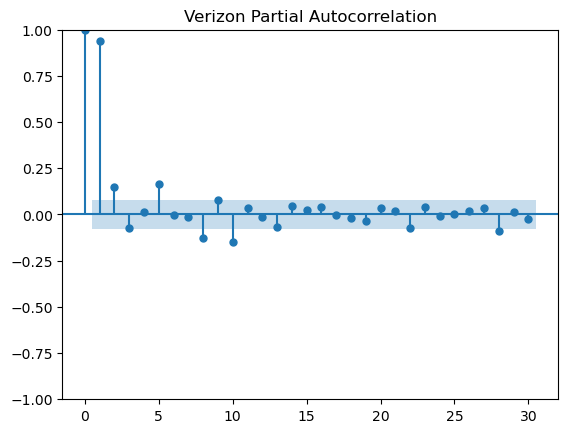

In [13]:
TSPlots(series_in = verizon_series, title = 'Verizon')

In [14]:
adfFunc(verizon_series)

ADF Statistic: -3.726362
p-value: 0.003757
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Assuming 95% confidence interval we reject null hypothesis that unit root present in the series (stationary series)


Observations:
* Gradually decreasing ACF plot with first 20 lags significantly diffrent than 0 suggest that Verizon stock price is not stationary (we need to 1st prder difference to series and then re-check)
* PACF Plot with multiple significant lags (1, 2, 5, 8, 9, 10, 22, 28) doesn't indicate particular seasonality as significant lags are not in regular intervals
* Augmented Dickey-Fuller test suggests stationarity of series (in opposition to trend decomposition function & ACF plot).

Conclusion:  
* This suggests we should model MA(q) (Moving average) transformation of series and re-do the evaluation.

In [15]:
verizon_diff1 = verizon_series.diff().fillna(0)

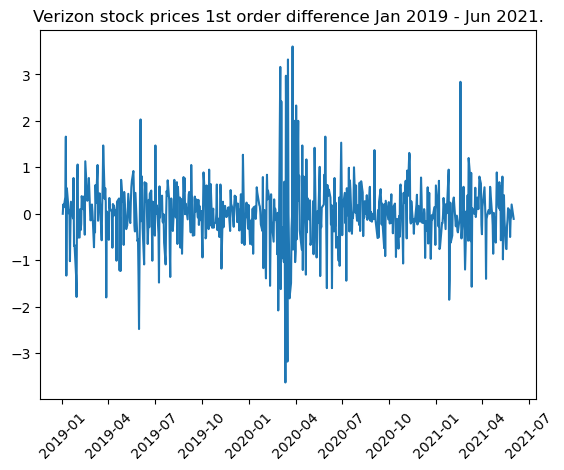

In [16]:
plt.plot(verizon_diff1, label='Verizon')
plt.xticks(rotation=45)
plt.title('Verizon stock prices 1st order difference Jan 2019 - Jun 2021.')
plt.show()

Lags with statistically significant autocorrelation
[1, 4, 7, 8, 9, 10, 13, 22]
Time series is non random - consider ARMA(p,q) adjustments.


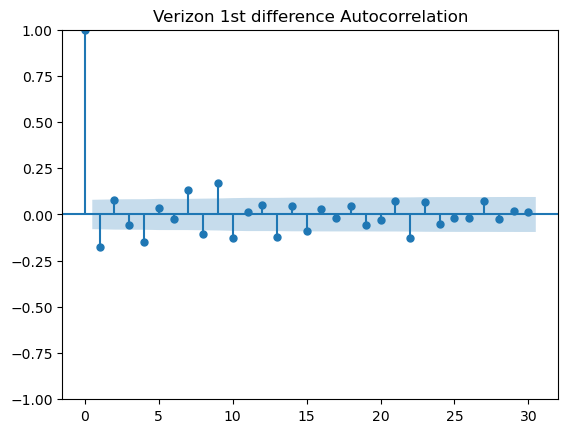

Lags with statistically significant partial autocorrelation
[1, 4, 7, 8, 9, 27]
Time series is non random - consider ARMA(p,q) adjustments.


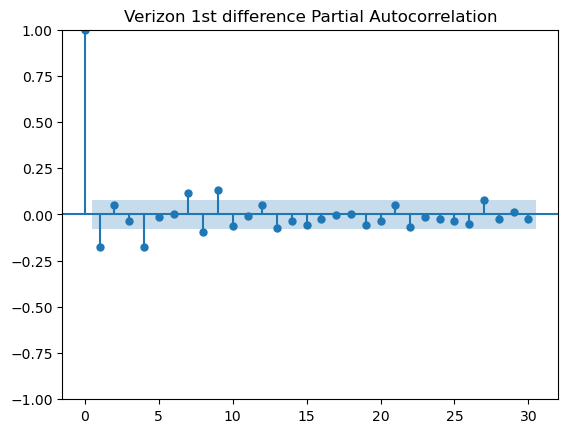

In [17]:
TSPlots(series_in = verizon_diff1, title = 'Verizon 1st difference')

In [18]:
adfFunc(verizon_diff1)


ADF Statistic: -7.890558
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Assuming 95% confidence interval we reject null hypothesis that unit root present in the series (stationary series)


Both original series and differentiated series pass ADF test for stationarity assuming 99% confidence interval. However ACF plot in my opinion indicated non-stationary process henceforth we will choose to go forward with 1st differencing. We will see if that will produce better results at the end.

#### 2.1 AT&T Corporation

AT&T Corporation is a US telecom company providing internet, mobile and tv services.  
https://en.wikipedia.org/wiki/AT%26T_Corporation 

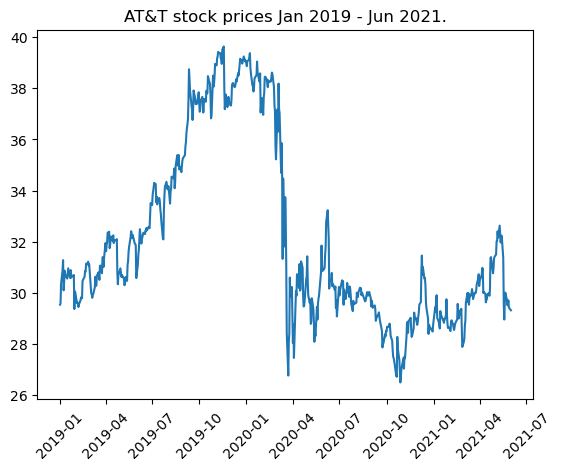

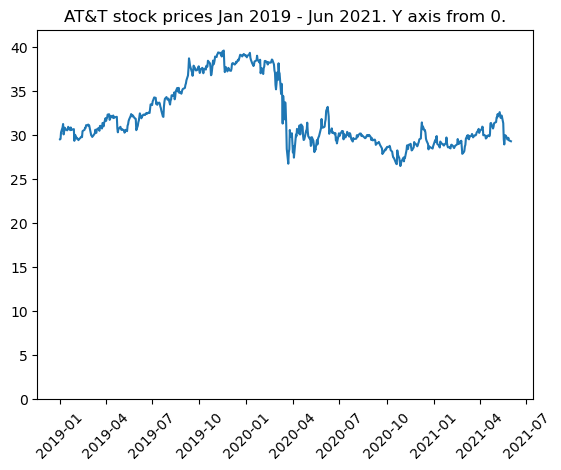

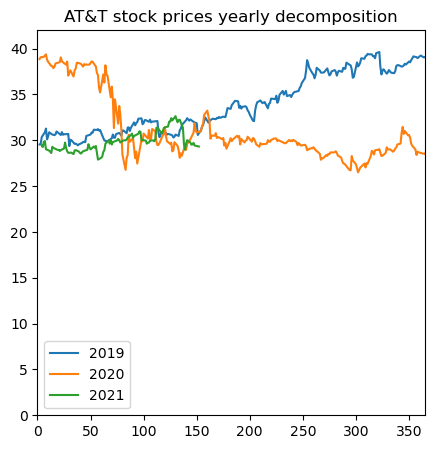

In [19]:
plt.plot(att_data['timestamp'], att_data['close'], label='AT&T')
plt.xticks(rotation=45)
plt.title('AT&T stock prices Jan 2019 - Jun 2021.')
plt.show()
plt.plot(att_data['timestamp'], att_data['close'], label='AT&T')
plt.xticks(rotation=45)
plt.ylim((0, 42))
plt.title('AT&T stock prices Jan 2019 - Jun 2021. Y axis from 0.') # to see true magnitude of changes
plt.show()
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(att_data[att_data['year'] == 2019]['day'], att_data[att_data['year'] == 2019]['close'], label='2019')
ax.plot(att_data[att_data['year'] == 2020]['day'], att_data[att_data['year'] == 2020]['close'], label='2020')
ax.plot(att_data[att_data['year'] == 2021]['day'], att_data[att_data['year'] == 2021]['close'], label='2021')
plt.xlim((0, 365))
plt.ylim((0, 42))
plt.title('AT&T stock prices yearly decomposition')
plt.legend()
plt.show()

Looking at the yearly decomposition of stock valuation I don't see a clear seasonal component. There was a upward trend present until abrupt decrease in valuation around COVID (March 2020). Afterwards I don't asee a clear trend.

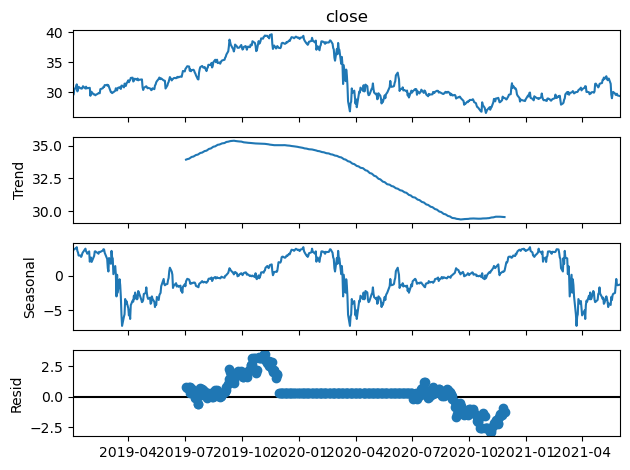

In [20]:
att_series = att_data.set_index('timestamp')['close'].squeeze()
result = seasonal_decompose(att_series, model = 'additive', period = 252) # 252 - number of trading days in a year
result.plot()
pyplot.show()


Based on seasonal seasonal decomposition function:
1) There is a clear downward trend. More trend data would be availbe if we analysed a broader timeframe.
2) There is a seasonal component driving stock prices down each April (maybe this is common for telecommunications sector? Would require broarder knowledge on the subject).
3) Middle period 2019-12 to 2020-07 seems well explained by seasonal and trend componens (residuals close to 0), previous to that remainders are over 0 (seasonal and trend componens suggest lower stock valuation than observed) vs opposite scenario after 2020-07 when remainders are negative.

Lags with statistically significant autocorrelation
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Time series is non random - consider ARMA(p,q) adjustments.


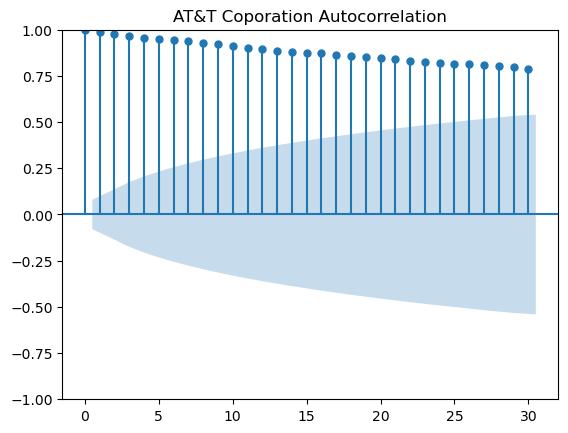

Lags with statistically significant partial autocorrelation
[1, 2, 5, 7, 8, 10, 14, 28, 30]
Time series is non random - consider ARMA(p,q) adjustments.


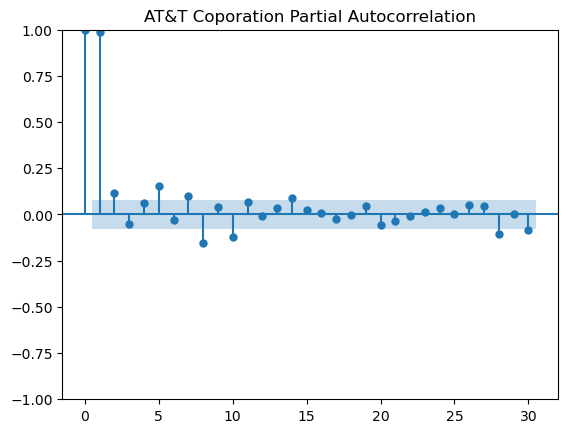

In [21]:
TSPlots(series_in = att_series, title = 'AT&T Coporation')

In [22]:
adfFunc(att_series)

ADF Statistic: -1.363302
p-value: 0.599738
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Assuming 95% confidence interval we have no grounds to reject null hypothesis that unit root present in the series (non-stationary series)


Observations:
* Gradually decreasing ACF plot with all 30 lags significantly diffrent than 0 suggest that AT&T stock price is not stationary  (we need to 1st prder difference to series and then re-check).
* PACF Plot with multiple significant lags (1, 2, 5, 7, 8, 10, 14, 28, 30) doesn't indicate particular seasonality as significant lags are not in regular intervals.
* Augmented Dickey-Fuller test suggests non-stationarity of series.

Conclusion:  
* This suggests we should model MA(q) (Moving average) transformation of series and re-do the evaluation.

In [23]:
att_diff1 = att_series.diff().fillna(0)

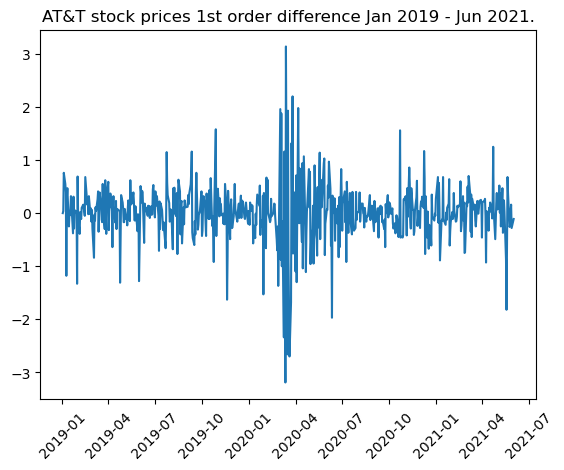

In [24]:
plt.plot(att_diff1, label='AT&T')
plt.xticks(rotation=45)
plt.title('AT&T stock prices 1st order difference Jan 2019 - Jun 2021.')
plt.show()

Lags with statistically significant autocorrelation
[1, 4, 6, 7, 8, 9, 13, 16]
Time series is non random - consider ARMA(p,q) adjustments.


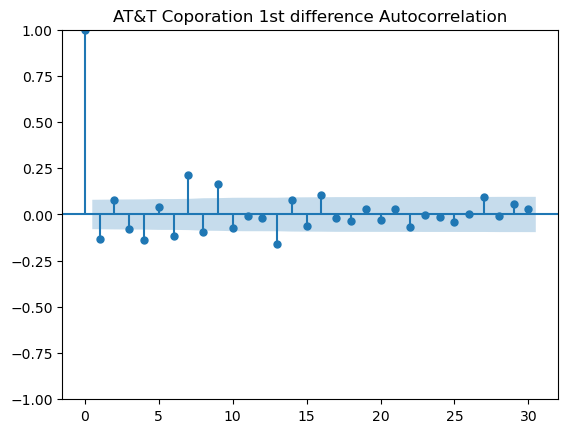

Lags with statistically significant partial autocorrelation
[1, 4, 6, 7, 9, 13, 27, 29]
Time series is non random - consider ARMA(p,q) adjustments.


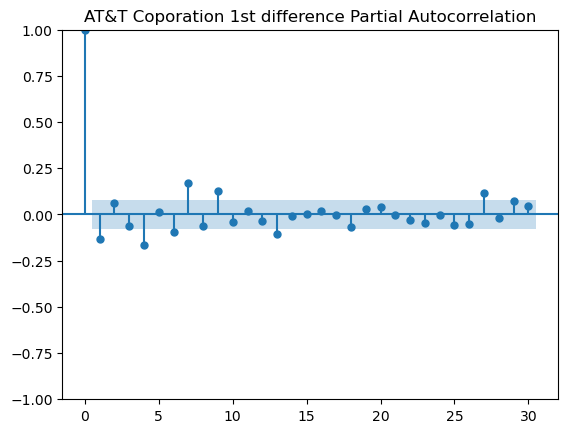

In [25]:
TSPlots(series_in = att_diff1, title = 'AT&T Coporation 1st difference')

In [26]:
adfFunc(att_diff1)

ADF Statistic: -7.487905
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Assuming 95% confidence interval we reject null hypothesis that unit root present in the series (stationary series)


While differentiating series with 1st order of difference removed stationarity we still need to inspect AR (auto-regression) and MA (moving-average) components.

In [49]:
y_train, y_test = train_test_split(att_series.reset_index()["close"], test_size=0.1, shuffle=False)


ARMAmodel = SARIMAX(att_series.reset_index()["close"], order = (1, 1, 3))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(y_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = y_test.index
y_pred_out = y_pred_df["Predictions"] 

In [ ]:
Działać coś na tym - tutaj więcej szans na poprawne wykonanie
https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

In [51]:
y_pred_out.head(30)
y_pred_df.head(30)

,lower close,upper close,Predictions
547,28.2541,30.3607,29.3074
548,27.9331,30.7164,29.3247
549,27.6457,31.0773,29.3615
550,27.4492,31.3056,29.3774
551,27.2865,31.4820,29.3842
552,27.1409,31.6334,29.3872
553,27.0063,31.7706,29.3885
554,26.8797,31.8984,29.3890
555,26.7594,32.0191,29.3893
556,26.6446,32.1342,29.3894


In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
# Problem to ponder: if we forecast time series for stock prices -> shouldn't we copy last close price to holidays and weekend? Wouldn't it be more true consideration? (Altough no trading is allowed and contracts will be exceuted only on the next trading day)

# Sarimax to DEBUG - for different type of models SARIMAX, GARCH etc. - we could use dictionaries with different param numbers re GP22
def rolling_forecast(data_in: pd.Series, window,  test_size = 0.1, var_name = "close"):
    pred_MA = []
    data_in = data_in.reset_index()[var_name]
    y_train, y_test = train_test_split(data_in, test_size=test_size, shuffle=False)
    print('train shape:', y_train.shape)
    print('test shape:', y_test.shape)
    print('input shape:', att_diff1.shape)
    assert (y_train.shape[0] + y_test.shape[0]) == data_in.shape[0], "Number of train + test obs doesn't match input data"

    models_df = pd.DataFrame({'Model':str(), 'P':int(), 'D':int(),'Q':int(),'s':int()}, index=[])
    # https://sparkbyexamples.com/pandas/pandas-add-row-to-dataframe    
    list = ["s(0)AR(0)I(0)MA(1)", 0, 0, 1, 0]
    models_df.loc[len(models_df)] = list
    print(models_df.head())

    for i in range(y_train.shape[0], data_in.shape[0], window):
            print(i)
            if models_df['s'][0] > 0:
                model = SARIMAX(data_in[:i].reset_index()[var_name], seasonal_order=(models_df['P'][0], models_df['D'][0], models_df['Q'][0], models_df['s'][0]))
            else:
                model = SARIMAX(data_in[:i].reset_index()[var_name], order=(models_df['P'][0], models_df['D'][0], models_df['Q'][0]))
            res = model.fit(disp=False)
            predictions = res.get_forecast(window) # -1)
            print(predictions.summary_frame(alpha=0.05))
            oos_pred = predictions.predicted_mean
            # get prediction vs get forecast - testowanie dalej
            print(oos_pred)
            pred_MA.extend(oos_pred)
    return pred_MA

In [28]:
rolling_forecast(data_in = att_diff1, window = 2)

train shape: (547,)
test shape: (61,)
input shape: (608,)
                Model  P  D  Q  s
0  s(0)AR(0)I(0)MA(1)  0  0  1  0
547
close    mean  mean_se  mean_ci_lower  mean_ci_upper
547   -0.0373   0.5540        -1.1230         1.0485
548    0.0000   0.5592        -1.0959         1.0959
547   -0.0373
548    0.0000
Name: predicted_mean, dtype: float64
549
close    mean  mean_se  mean_ci_lower  mean_ci_upper
549   -0.0628   0.5542        -1.1491         1.0234
550    0.0000   0.5592        -1.0960         1.0960
549   -0.0628
550    0.0000
Name: predicted_mean, dtype: float64
551
close    mean  mean_se  mean_ci_lower  mean_ci_upper
551   -0.0421   0.5535        -1.1269         1.0427
552    0.0000   0.5585        -1.0947         1.0947
551   -0.0421
552    0.0000
Name: predicted_mean, dtype: float64
553
close    mean  mean_se  mean_ci_lower  mean_ci_upper
553   -0.0292   0.5528        -1.1128         1.0543
554    0.0000   0.5580        -1.0936         1.0936
553   -0.0292
554    0.0000

[-0.037260811496400495,
 0.0,
 -0.06281371255392103,
 0.0,
 -0.04209479657268486,
 0.0,
 -0.029223246865279613,
 0.0,
 -0.010926135564160385,
 0.0,
 0.01588673766618209,
 0.0,
 -0.02640040621931837,
 0.0,
 0.000686837411752129,
 0.0,
 -0.03295789327101673,
 0.0,
 -0.02819656514231779,
 0.0,
 -0.019237408172583372,
 0.0,
 -0.041408294868940876,
 0.0,
 0.12653597883485104,
 0.0,
 0.012406518194541893,
 0.0,
 -0.007261797569164003,
 0.0,
 -0.027543511632217816,
 0.0,
 0.012285303881737387,
 0.0,
 -0.17118333070766267,
 0.0,
 0.061643971291527336,
 0.0,
 -0.02173796504401815,
 0.0,
 -0.016362913841674785,
 0.0,
 -0.07062576774189185,
 0.0,
 -0.051440798148359064,
 0.0,
 -0.058776637602388125,
 0.0,
 0.04396320458524062,
 0.0,
 -0.007458222451855415,
 0.0,
 0.24068659568492345,
 0.0,
 -0.06954174478184486,
 0.0,
 0.024716106731308595,
 0.0,
 3.0212871872046207e-05,
 0.0,
 0.03106052584320658,
 0.0]

In [41]:
# https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html
# https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

pred_MA = []
att_diff_DF = pd.DataFrame(att_diff1)
print(att_diff_DF.head())
model = SARIMAX(endog = att_diff_DF[:555].reset_index()["close"], order=(0,0,2))
res = model.fit()
predictions = res.get_prediction(dynamic = 547, end = 555)
predictionsf = res.get_forecast(steps = 6)
predictionsf2 = res.forecast(steps = 6)
print('predictions dynamic',predictions.predicted_mean.head(10))


print(predictionsf.summary_frame(alpha=0.05))
print('forecast', predictionsf.predicted_mean)
print(predictionsf2)

oos_pred = predictions.predicted_mean.iloc[-2:]
pred_MA.extend(oos_pred)
print('true',att_diff1[547:550])
print('predicted mean',predictions.predicted_mean)
print('oos pred',oos_pred)
print('pred ma', pred_MA)

            close
timestamp        
2019-01-02 0.0000
2019-01-03 0.0400
2019-01-04 0.7600
2019-01-07 0.5500
2019-01-08 0.3900
predictions dynamic 0    0.0000
1    0.0000
2   -0.0048
3   -0.0893
4    0.0042
5    0.0217
6    0.1883
7   -0.1429
8   -0.0628
9    0.0888
Name: predicted_mean, dtype: float64
close   mean  mean_se  mean_ci_lower  mean_ci_upper
555   0.0124   0.5498        -1.0652         1.0899
556   0.0066   0.5539        -1.0790         1.0922
557   0.0000   0.5570        -1.0918         1.0918
558   0.0000   0.5570        -1.0918         1.0918
559   0.0000   0.5570        -1.0918         1.0918
560   0.0000   0.5570        -1.0918         1.0918
forecast 555   0.0124
556   0.0066
557   0.0000
558   0.0000
559   0.0000
560   0.0000
Name: predicted_mean, dtype: float64
555   0.0124
556   0.0066
557   0.0000
558   0.0000
559   0.0000
560   0.0000
Name: predicted_mean, dtype: float64
true timestamp
2021-03-05    0.7000
2021-03-08    0.3700
2021-03-09   -0.3500
Name: close, dty

In [30]:
rolling_forecast(data_in = att_diff1)


TypeError: rolling_forecast() missing 1 required positional argument: 'window'

In [ ]:
rolling_forecast(data_in = att_series)

train shape: (547,)
test shape: (61,)
input shape: (608,)
                Model  P  D  Q  s
0  s(0)AR(0)I(0)MA(1)  0  0  1  0


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[15.644764663377806,
 0.0,
 16.035523937205962,
 0.0,
 16.35535733656187,
 0.0,
 16.643458043260246,
 0.0,
 16.69595211371128,
 0.0,
 16.551140003601944,
 0.0,
 16.74689116645331,
 0.0,
 16.757428394908988,
 0.0,
 16.952320974538903,
 0.0,
 17.14832115879631,
 0.0,
 17.333984055005047,
 0.0,
 17.57836307267522,
 0.0,
 16.63851335848707,
 0.0,
 16.574319703772023,
 0.0,
 16.672096063771807,
 0.0,
 16.85398596555179,
 0.0,
 16.761240437486954,
 0.0,
 17.986332266954992,
 0.0,
 17.462149643100517,
 0.0,
 17.68325052900008,
 0.0,
 17.708168252864567,
 0.0,
 18.24312132920228,
 0.0,
 18.609533758447697,
 0.0,
 19.072307617022748,
 0.0,
 18.75973880343648,
 0.0,
 18.805383589671155,
 0.0,
 16.986725121438095,
 0.0,
 17.634864697736305,
 0.0,
 17.392796969471593,
 0.0,
 17.34958621058673,
 0.0,
 17.09687367607399,
 0.0]

In [ ]:
print(len(pred_MA))
print(len(oos_pred))
print(oos_pred)

4
2
547    0.0140
548   -0.0557
Name: predicted_mean, dtype: float64


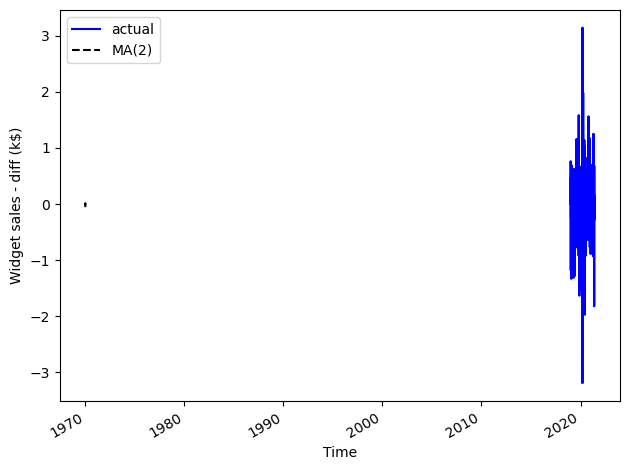

In [ ]:


fig, ax = plt.subplots()

ax.plot(att_diff1)
ax.plot(att_diff1, 'b-', label='actual')
ax.plot(pred_MA, 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

# ax.axvspan(449, 498, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
blablakacz

NameError: name 'blablakacz' is not defined

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
def rolling_forecast(df: pd.Series, train_len: int, horizon: int, 
 window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
 
        return pred_mean
 
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)


            
        return pred_MA

In [ ]:
pred_df = test.copy()
 
TRAIN_LEN = len(y_train)
HORIZON = len(y_test)
WINDOW = 2
 
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')
 
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA
 
pred_df.head()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

ValueError: Length of values (62) does not match length of index (61)

In [ ]:
pred_df = test.copy()
 
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2
 
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 
 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')
 
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA
 
pred_df.head()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

ValueError: Length of values (62) does not match length of index (61)